<a href="https://colab.research.google.com/github/bharatchudasama/Mobile_price_Pridiction/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from catboost import CatBoostRegressor


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#PREPROCESSING
import pandas as pd


url = 'https://raw.githubusercontent.com/bharatchudasama/Mobile_price_Pridiction/refs/heads/main/DATA%20SET/Mobile-Phones.csv'

data = pd.read_csv(url)

for column in data.columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

def extract_camera_features(camera_str):
    numbers = re.findall(r'\d+', str(camera_str))
    numbers = list(map(int, numbers))
    return max(numbers) if numbers else 0

data['main_camera_max_mp'] = data['main_camera'].apply(extract_camera_features)
data.drop(columns=['main_camera'], inplace=True)

def extract_resolution(res_str):
    try:
        width, height = map(int, re.findall(r'\d+', str(res_str)))
        return width * height
    except ValueError:
        return np.nan

data['total_pixels'] = data['resolution'].apply(extract_resolution)
data['total_pixels'].fillna(data['total_pixels'].median(), inplace=True)
data.drop(columns=['resolution'], inplace=True)

label_encoder = LabelEncoder()
data['sd_card'] = label_encoder.fit_transform(data['sd_card'])
data['sim_card'] = label_encoder.fit_transform(data['sim_card'])

data = pd.get_dummies(data, columns=['brand', 'model', 'display', 'os', 'color', 'region', 'location'], drop_first=True)

numerical_cols = ['screen_size(inch)', 'battery(mAh)', 'storage(GB)', 'ram(GB)', 'selfie_camera(MP)', 'main_camera_max_mp', 'total_pixels']
target_col = 'price(¢)'

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

data[numerical_cols] = feature_scaler.fit_transform(data[numerical_cols])
data[target_col] = target_scaler.fit_transform(data[[target_col]])


<ipython-input-2-9ec29e097628>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
<ipython-input-2-9ec29e097628>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

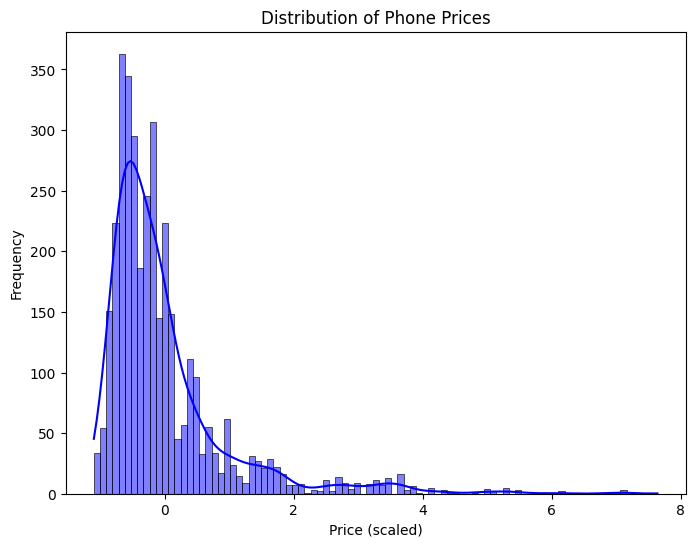

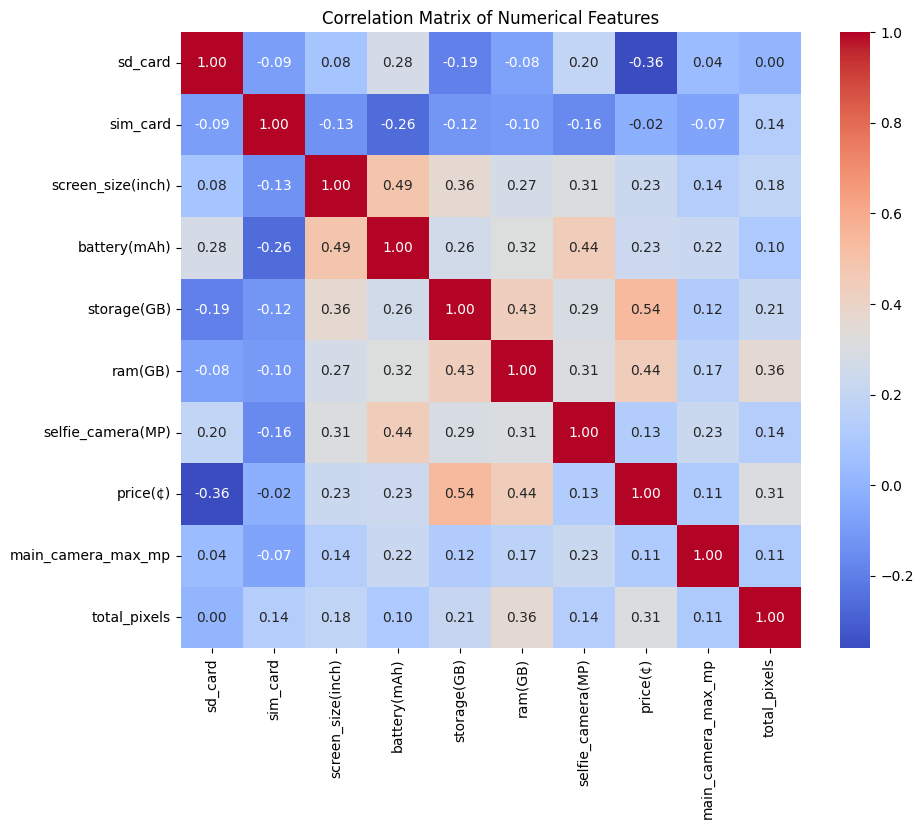

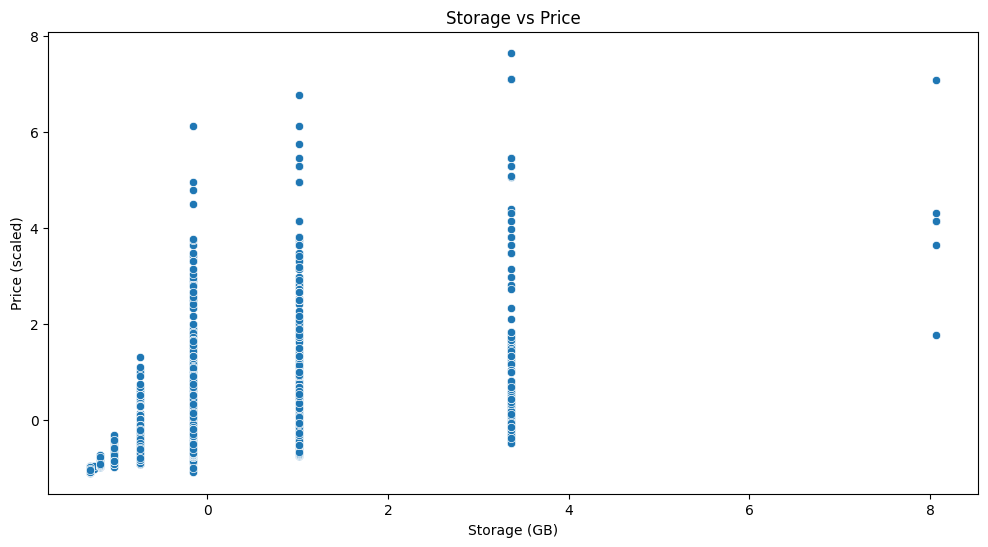

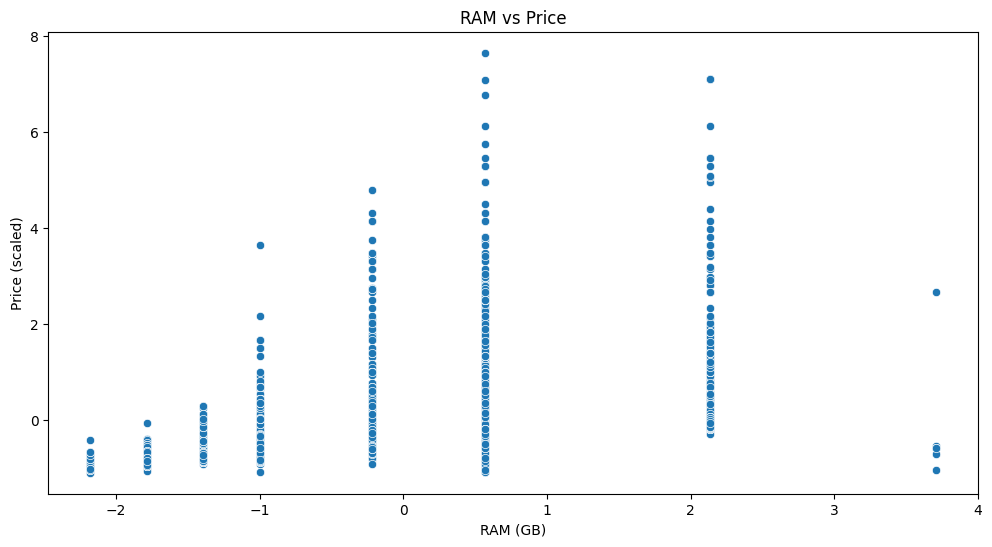

In [3]:
#VISUALIZATION
plt.figure(figsize=(8, 6))
sns.histplot(data['price(¢)'], kde=True, color='blue')
plt.title('Distribution of Phone Prices')
plt.xlabel('Price (scaled)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 8))
# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='storage(GB)', y='price(¢)')
plt.title('Storage vs Price')
plt.xlabel('Storage (GB)')
plt.ylabel('Price (scaled)')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='ram(GB)', y='price(¢)')
plt.title('RAM vs Price')
plt.xlabel('RAM (GB)')
plt.ylabel('Price (scaled)')
plt.show()


Model Evaluation:
Mean Squared Error: 0.06246320556829879
R-squared Score: 0.9404331394489569


<ipython-input-23-0d44ac938b30>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, color='red')


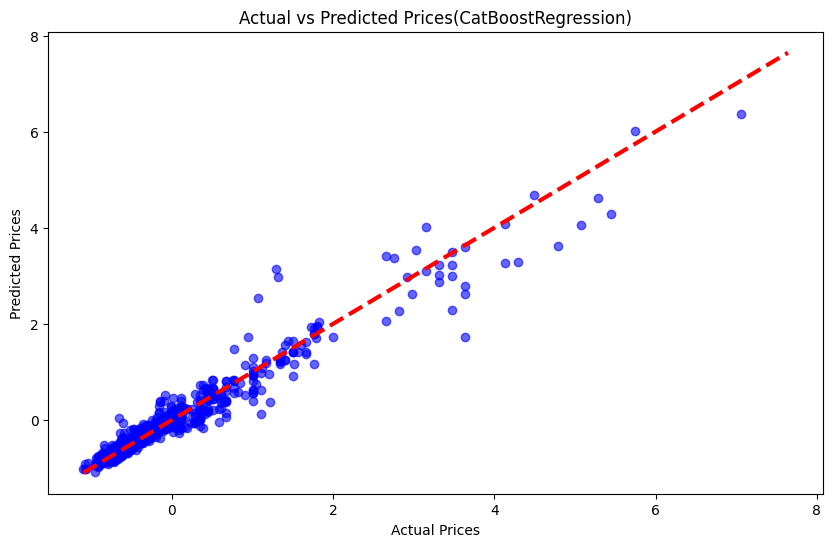

In [23]:
#TRAINING
X = data.drop('price(¢)', axis=1)
y = data['price(¢)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices(CatBoostRegression)')
plt.show()

In [18]:
#PREDICTION

In [19]:
brands = [
    "brand_Samsung", "brand_Tecno", "brand_LG", "brand_Vivo", "brand_Huawei", "brand_Infinix", "brand_Apple",
    "brand_Google", "brand_Oppo", "brand_Nokia", "brand_Other Brand", "brand_Itel", "brand_Motorola",
    "brand_Realme", "brand_Xiaomi", "brand_Meizu", "brand_OnePlus", "brand_Bontel", "brand_HTC",
    "brand_X-Tigi", "brand_Honor"
]
displays = [
    "display_AMOLED", "display_Super AMOLED", "display_IPS LCD", "display_P-OLED", "display_IPS",
    "display_OLED", "display_TFT", "display_PLS LCD", "display_Super Retina OLED", "display_Retina IPS LCD",
    "display_G-OLED", "display_P-OLED+", "display_PLS", "display_Monochrome", "display_Super LCD3",
    "display_Dynamic AMOLED", "display_TN", "display_Retina IPS", "display_Dynamic AMOLED / Dynamic AMOLED"
]
colors = ["color_White", "color_Bronze", "color_Black", "color_Blue", "color_Green", "color_Silver", "color_Gold",
          "color_Gray", "color_Pink", "color_Yellow", "color_Other", "color_Rose Gold", "color_Purple",
          "color_Red", "color_Orange"]
models = [
    "model_Galaxy S10", "model_Galaxy Note 20 Ultra", "model_Galaxy A54 5G", "model_Camon 20 Pro",
    "model_Galaxy S22 Ultra", "model_Galaxy A73 5G", "model_Galaxy S23 Ultra", "model_Camon 20 Premier 5G"
]
regions = ["region_Greater Accra", "region_Ashanti", "region_Eastern Region"]
locations = [
    "location_Circle", "location_Accra Metropolitan", "location_Kokomlemle", "location_Dzorwulu",
    "location_Kumasi Metropolitan", "location_Abokobi", "location_Roman Ridge", "location_Pokuase"
]
oses = ["os_Android", "os_iOS", "os_Harmony", "os_Symbian", "os_Windows Mobile", "os_Java", "os_Nucleus OS"]

In [20]:
sd_card_mapping = {'yes': 1, 'no': 0}
sim_card_mapping = {'Single': 1, 'Dual': 0}

def add_all_categorical_features(input_data, selected_brand, selected_display, selected_color, selected_model, selected_region, selected_location, selected_os):
    for brand in brands:
        input_data[brand] = 0
    input_data[f"brand_{selected_brand}"] = 1 if f"brand_{selected_brand}" in brands else 0
    for display in displays:
        input_data[display] = 0
    input_data[f"display_{selected_display}"] = 1 if f"display_{selected_display}" in displays else 0
    for color in colors:
        input_data[color] = 0
    input_data[f"color_{selected_color}"] = 1 if f"color_{selected_color}" in colors else 0
    for model in models:
        input_data[model] = 0
    input_data[f"model_{selected_model}"] = 1 if f"model_{selected_model}" in models else 0
    for region in regions:
        input_data[region] = 0
    input_data[f"region_{selected_region}"] = 1 if f"region_{selected_region}" in regions else 0
    for location in locations:
        input_data[location] = 0
    input_data[f"location_{selected_location}"] = 1 if f"location_{selected_location}" in locations else 0
    for os in oses:
        input_data[os] = 0
    input_data[f"os_{selected_os}"] = 1 if f"os_{selected_os}" in oses else 0
    return input_data


In [21]:
def predict_price(model, feature_scaler, target_scaler, input_data):
    input_df = pd.DataFrame([input_data])
    input_df['sd_card'] = input_df['sd_card'].map(sd_card_mapping)
    input_df['sim_card'] = input_df['sim_card'].map(sim_card_mapping)
    input_df['total_pixels'] = input_df['width'] * input_df['height']
    input_df = input_df.drop(columns=['width', 'height'])
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    input_df[numerical_cols] = feature_scaler.transform(input_df[numerical_cols])
    scaled_predicted_price = model.predict(input_df[X.columns])[0]
    original_predicted_price = target_scaler.inverse_transform([[scaled_predicted_price]])[0][0]
    return original_predicted_price

input_data = {
    "sd_card": "yes",
    "sim_card": "Dual",
    "screen_size(inch)": 6.7,
    "battery(mAh)": 5000,
    "storage(GB)": 128,
    "ram(GB)": 4,
    "selfie_camera(MP)": 16,
    "main_camera_max_mp": 50,
    "width": 1440,
    "height": 3040,
}
input_data = add_all_categorical_features(
    input_data, selected_brand="Samsung", selected_display="AMOLED", selected_color="White",
    selected_model="Galaxy S10", selected_region="Greater Accra", selected_location="Circle",
    selected_os="Android"
)
predicted_price = predict_price(model, feature_scaler, target_scaler, input_data)
print("Predicted Price:", predicted_price)

<ipython-input-21-d6d279fe4818>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[col] = 0
<ipython-input-21-d6d279fe4818>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[col] = 0
<ipython-input-21-d6d279fe4818>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[col] = 0
<ipy

Predicted Price: 4031.9741110855157
